### Importing the libraries and data

In [1]:
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
!pip install geopandas
!pip install xgboost
!pip install pydot

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/util.py:25: Crypto

In [3]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers, callbacks
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [4]:
df_amsterdam = pd.read_csv("amsterdam_cleaned.csv.gz")
df_amsterdam["gdp_city"] = 172

In [5]:
df_paris = pd.read_csv("paris_cleaned.csv.gz")
df_paris["gdp_city"] = 685

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df_berlin = pd.read_csv("berlin_cleaned.csv.gz")
df_berlin["gdp_city"] = 184

In [7]:
df_london = pd.read_csv("london_cleaned.csv.gz")
df_london["gdp_city"] = 801

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df = pd.concat([df_amsterdam,df_berlin,df_paris]).reset_index(drop=True)

In [9]:
df.drop(columns=["id","borough","amenities"], inplace=True)
df_london.drop(columns=["id","borough","amenities"], inplace=True)

In [10]:
transformed_df = pd.get_dummies(df)
transformed_london = pd.get_dummies(df_london)

In [11]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

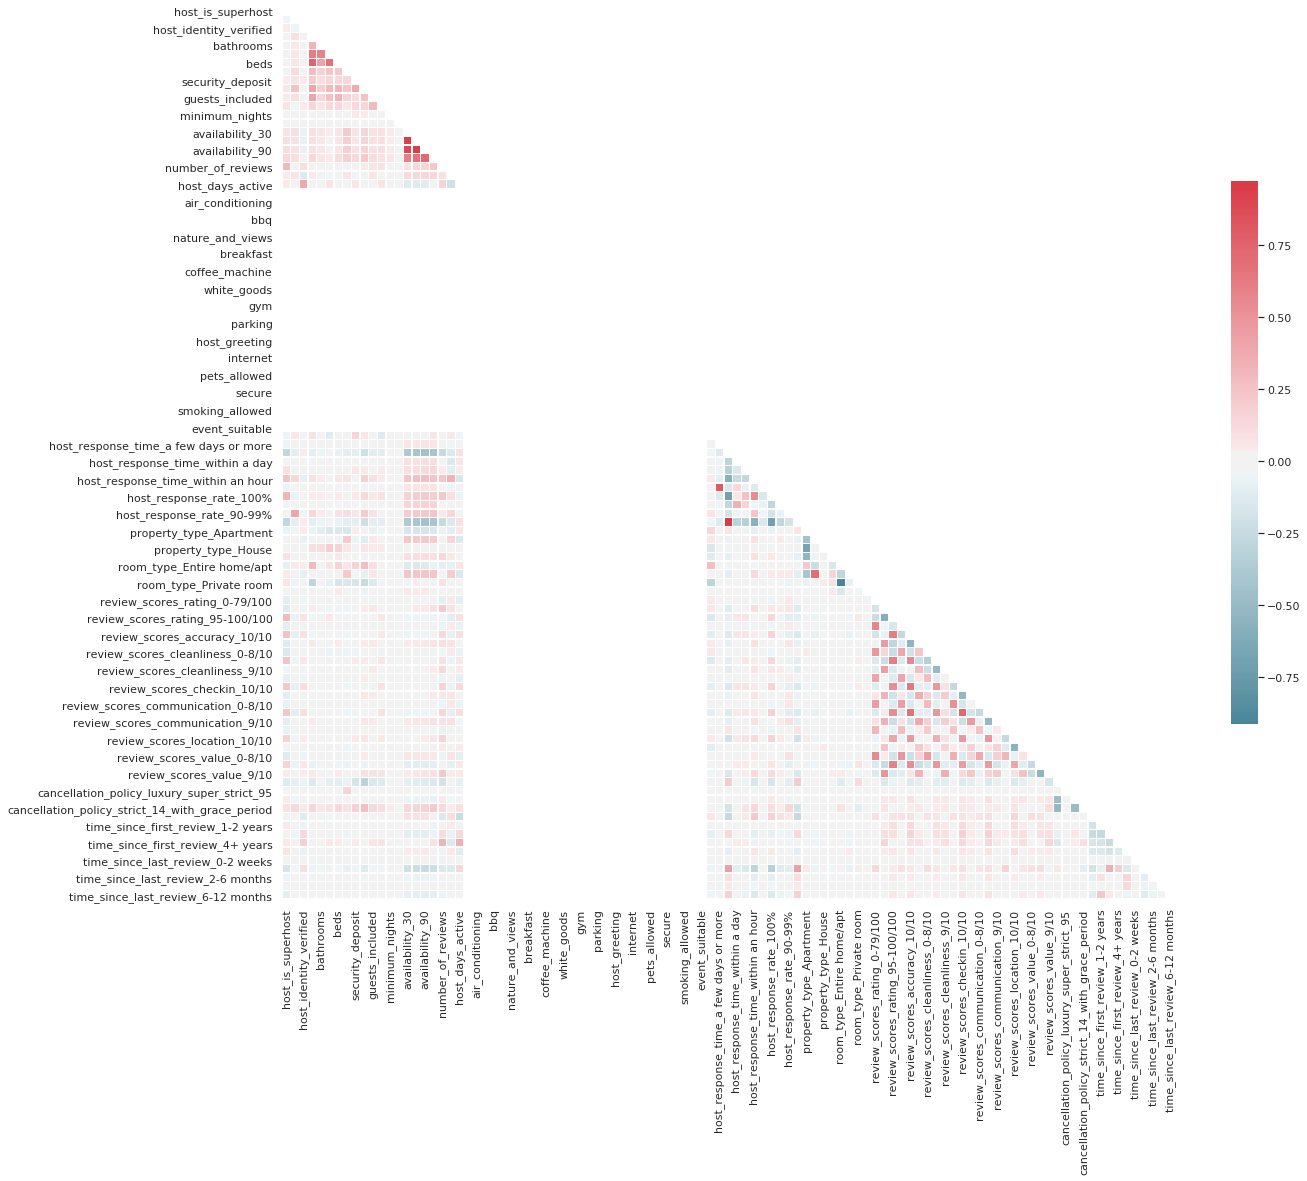

In [12]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

In [13]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)
transformed_london.drop(to_drop, axis=1, inplace=True)

In [14]:
transformed_df

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,...,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
0,1.0,1.0,0.0,2,1.5,59,200,60,20,3,...,0,0,0,1,0,0,0,0,0,0
1,0.0,2.0,0.0,2,1.0,80,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0.0,2.0,0.0,3,1.0,125,300,40,10,14,...,0,1,0,0,0,0,0,0,0,0
3,1.0,1.0,1.0,2,1.0,155,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0
4,1.0,3.0,1.0,2,1.0,75,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108870,0.0,0.0,0.0,4,1.0,84,252,60,0,1,...,0,0,0,0,0,0,0,0,0,0
108871,0.0,7.0,1.0,2,1.0,50,0,25,0,3,...,0,0,0,0,0,0,0,0,0,0
108872,0.0,1.0,0.0,2,1.0,72,216,48,0,1,...,0,0,0,0,0,0,0,0,0,0
108873,0.0,1.0,0.0,4,1.0,102,306,60,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
transformed_london

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,...,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
0,1.0,3.0,1.0,4,1.0,88,400,30,20,4,...,0,0,0,1,0,0,0,0,0,0
1,0.0,4.0,0.0,2,1.0,65,100,15,15,1,...,0,0,0,1,0,0,0,0,0,0
2,0.0,1.0,1.0,2,1.0,100,150,50,0,30,...,0,0,0,1,0,0,0,0,0,0
3,0.0,18.0,1.0,6,2.0,300,350,65,10,3,...,0,0,0,1,0,0,0,0,0,0
4,1.0,1.0,0.0,4,1.0,65,250,50,11,90,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83837,0.0,0.0,0.0,1,1.0,120,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
83838,0.0,7.0,0.0,11,1.0,409,0,45,15,1,...,0,0,0,0,0,0,0,0,0,0
83839,0.0,0.0,0.0,5,2.0,300,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
83840,0.0,11.0,0.0,6,1.0,110,250,70,15,3,...,0,0,0,0,0,0,0,0,0,0


In [16]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit','gdp_city']

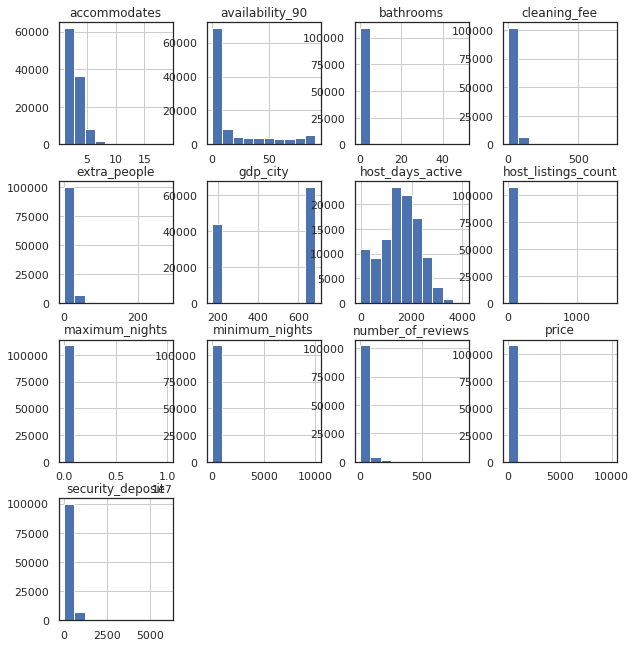

In [17]:
transformed_df[numerical_columns].hist(figsize=(10,11));

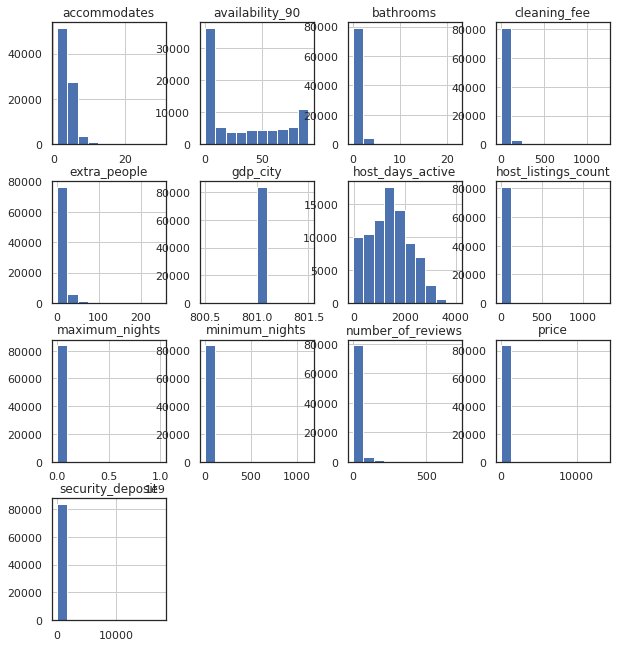

In [18]:
transformed_london[numerical_columns].hist(figsize=(10,11));

In [19]:
print(f"Nightly advertised prices range from ${min(transformed_df.price)} to ${max(transformed_df.price)}.")

Nightly advertised prices range from $0 to $10000.


In [20]:
print(f"Nightly advertised prices for Belin range from ${min(transformed_london.price)} to ${max(transformed_london.price)}.")

Nightly advertised prices for Belin range from $0 to $13700.


In [21]:
transformed_df.loc[transformed_df.price < 5, 'price'] = 5
transformed_london.loc[transformed_london.price < 5, 'price'] = 5

In [22]:
transformed_df.loc[transformed_df.price > 7000, 'price'] = 7000
transformed_london.loc[transformed_london.price > 7000, 'price'] = 7000

In [23]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active','gdp_city']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

for col in numerical_columns:
    transformed_london[col] = transformed_london[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_london[col] = np.log(transformed_london[col])

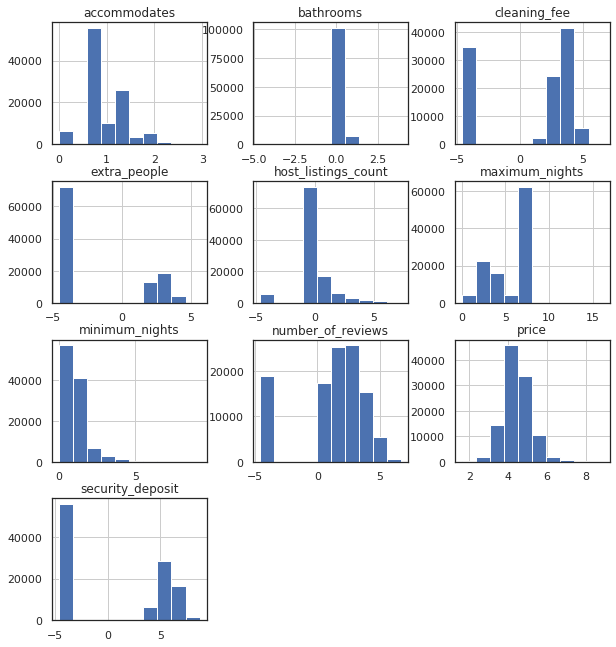

In [24]:
transformed_df[numerical_columns].hist(figsize=(10,11));

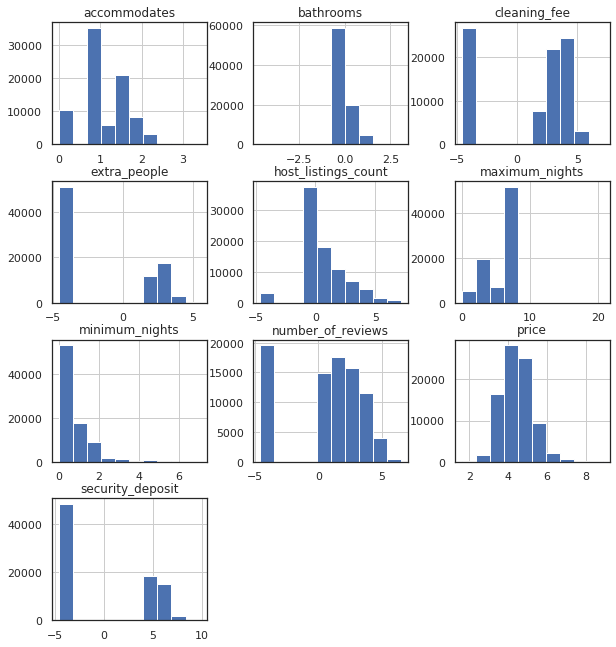

In [25]:
transformed_london[numerical_columns].hist(figsize=(10,11));

In [26]:
transformed_df["gdp_city"].unique()

array([172, 184, 685])

In [27]:
transformed_london["gdp_city"].unique()

array([801])

In [28]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [29]:
# Separating X and y
X_london = transformed_london.drop('price', axis=1)
y_london = transformed_london.price

#reuse the same scaling
X_london = pd.DataFrame(scaler.fit_transform(X_london), columns=list(X_london.columns))

In [30]:
common_columns = list(set(X_london.columns) & set(X.columns))

In [31]:
X= X[common_columns]
X_london = X_london[common_columns]

***

In this section several machine learning and deep learning models will be built in order to predict an Airbnb listing's price.

The evaluation metrics used will be mean squared error (for loss) and r squared (for accuracy).

In [32]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Model 1: XGBoost

In [33]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.1 minutes

Training MSE: 0.1054
Validation MSE: 0.1364

Training r2: 0.7848
Validation r2: 0.7249


In [34]:
london_test = xgb_reg.predict(X_london)
print("Validation london MSE:", round(mean_squared_error(y_london, london_test),4))
print("Validation london r2:", round(r2_score(y_london, london_test),4))

Validation london MSE: 0.2249
Validation london r2: 0.6344


In [35]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
review_scores_accuracy_10/10,0.001150
host_response_time_within an hour,0.001177
nature_and_views,0.001296
time_since_last_review_2-6 months,0.001345
time_since_first_review_4+ years,0.001386
...,...
bathrooms,0.043964
room_type_Entire home/apt,0.075878
room_type_Hotel room,0.092546
accommodates,0.115011


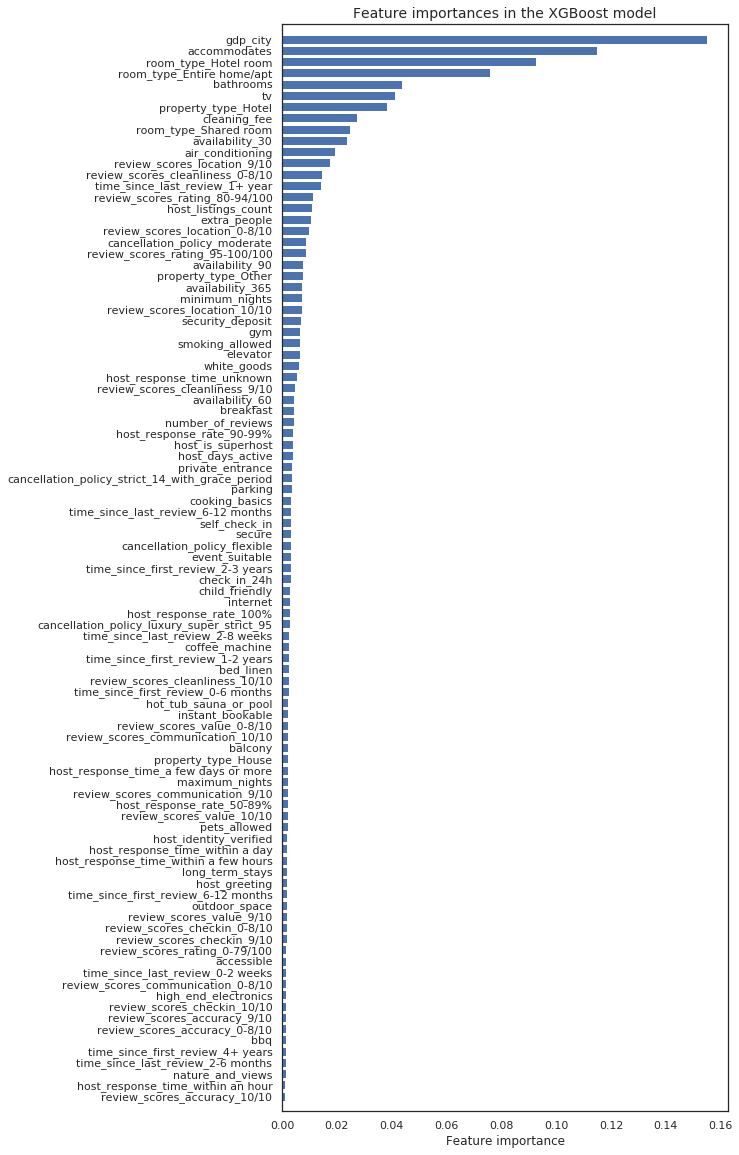

In [36]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

### Model 2: four-layer neural network

In [37]:
X_train = X_train.fillna(0)
X_london = X_london.fillna(0)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               49152     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 213,505
Trainable params: 213,505
Non-trainable params: 0
_________________________________________________________________
None


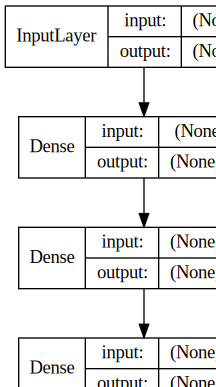

In [38]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
nn3.add(layers.Dense(256, activation='relu'))
nn3.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [39]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=512,
                  validation_data = (X_london, y_london))

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")


Train on 87100 samples, validate on 83842 samples
Epoch 1/50
87100/87100 [==============================] - 1s 16us/step - loss: 6.9389 - mean_squared_error: 0.9496 - val_loss: 3.2888 - val_mean_squared_error: 0.3347
Epoch 2/50
87100/87100 [==============================] - 1s 13us/step - loss: 2.1891 - mean_squared_error: 0.2257 - val_loss: 1.6372 - val_mean_squared_error: 0.3164
Epoch 3/50
87100/87100 [==============================] - 1s 13us/step - loss: 1.2371 - mean_squared_error: 0.2034 - val_loss: 1.1187 - val_mean_squared_error: 0.3022
Epoch 4/50
87100/87100 [==============================] - 1s 13us/step - loss: 0.8782 - mean_squared_error: 0.1959 - val_loss: 0.8827 - val_mean_squared_error: 0.3131
Epoch 5/50
87100/87100 [==============================] - 1s 13us/step - loss: 0.6781 - mean_squared_error: 0.1922 - val_loss: 0.7053 - val_mean_squared_error: 0.2948
Epoch 6/50
87100/87100 [==============================] - 1s 13us/step - loss: 0.5399 - mean_squared_error: 0.1881

In [40]:
# MSE and r squared values
X_test = X_test.fillna(0)
y_test_pred = nn3.predict(X_test)
y_train_pred = nn3.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 0.148
Validation MSE: 0.1982

Training r2: 0.6977
Validation r2: 0.6002


In [41]:
X_london = X_london.fillna(0)
london_test = nn3.predict(X_london)
print("Validation London MSE:", round(mean_squared_error(y_london, london_test),4))
print("Validation London r2:", round(r2_score(y_london, london_test),4))

Validation London MSE: 0.3055
Validation London r2: 0.5033


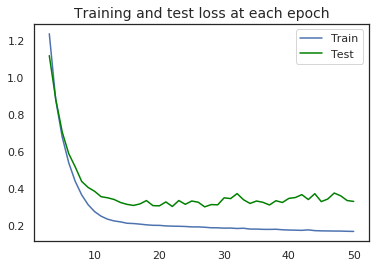

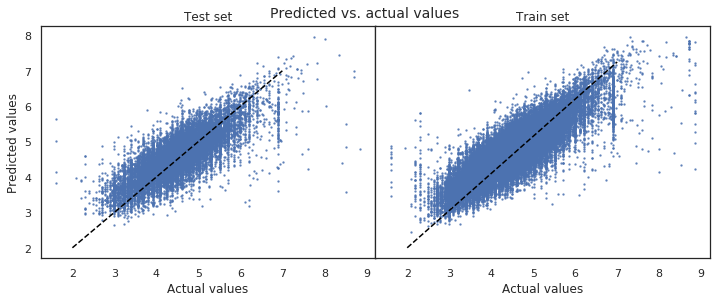

In [42]:
# Line graph of losses
skip_epochs = 2
nn3_results = nn3.history.history
plt.plot(list(range((skip_epochs+1),len(nn3_results['loss'])+1)), nn3_results['loss'][skip_epochs:], label='Train')
plt.plot(list(range((skip_epochs+1),len(nn3_results['val_loss'])+1)), nn3_results['val_loss'][skip_epochs:], label='Test', color='green')
plt.legend()
plt.title('Training and test loss at each epoch', fontsize=14)
plt.show()
    
# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)
    
ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
    
ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
    
plt.show()

### Model 3: Nueral Network modified

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               24576     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 156,417
Trainable params: 156,417
Non-trainable params: 0
_________________________________________________________________
None


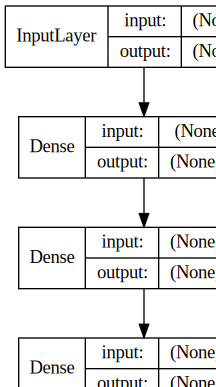

In [43]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(256, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256,  kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

# Visualising the neural network
SVG(model_to_dot(nn4, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [44]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=512,
                  validation_data = (X_london, y_london))

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

Train on 87100 samples, validate on 83842 samples
Epoch 1/50
87100/87100 [==============================] - 1s 14us/step - loss: 22.8438 - mean_squared_error: 0.7108 - val_loss: 8.2259 - val_mean_squared_error: 0.3620
Epoch 2/50
87100/87100 [==============================] - 1s 12us/step - loss: 4.3010 - mean_squared_error: 0.2590 - val_loss: 2.1200 - val_mean_squared_error: 0.2671
Epoch 3/50
87100/87100 [==============================] - 1s 12us/step - loss: 1.3380 - mean_squared_error: 0.2302 - val_loss: 0.8895 - val_mean_squared_error: 0.2581
Epoch 4/50
87100/87100 [==============================] - 1s 12us/step - loss: 0.6596 - mean_squared_error: 0.2294 - val_loss: 0.5484 - val_mean_squared_error: 0.2565
Epoch 5/50
87100/87100 [==============================] - 1s 12us/step - loss: 0.4582 - mean_squared_error: 0.2271 - val_loss: 0.4467 - val_mean_squared_error: 0.2576
Epoch 6/50
87100/87100 [==============================] - 1s 12us/step - loss: 0.3965 - mean_squared_error: 0.2263

In [45]:
# MSE and r squared values
X_test = X_test.fillna(0)
y_test_pred = nn4.predict(X_test)
y_train_pred = nn4.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 0.2081
Validation MSE: 0.2122

Training r2: 0.575
Validation r2: 0.5721


In [46]:
X_london = X_london.fillna(0)
london_test = nn4.predict(X_london)
print("Validation London MSE:", round(mean_squared_error(y_london, london_test),4))
print("Validation London r2:", round(r2_score(y_london, london_test),4))

Validation London MSE: 0.2589
Validation London r2: 0.579


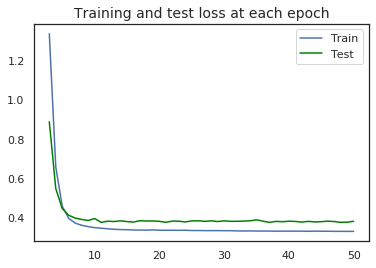

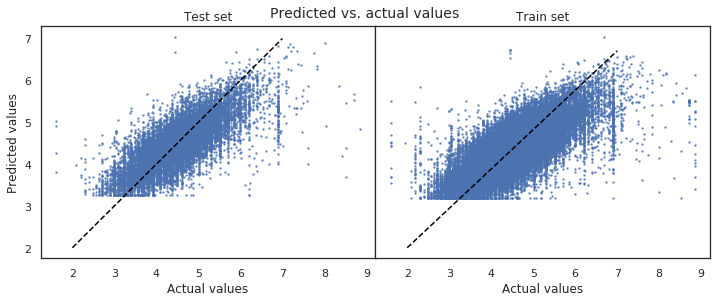

In [47]:
# Line graph of losses
skip_epochs = 2
nn3_results = nn4.history.history
plt.plot(list(range((skip_epochs+1),len(nn3_results['loss'])+1)), nn3_results['loss'][skip_epochs:], label='Train')
plt.plot(list(range((skip_epochs+1),len(nn3_results['val_loss'])+1)), nn3_results['val_loss'][skip_epochs:], label='Test', color='green')
plt.legend()
plt.title('Training and test loss at each epoch', fontsize=14)
plt.show()
    
# Scatterplot of predicted vs. actual values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
plt.subplots_adjust(top=0.93, wspace=0)
    
ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax1.set_title('Test set')
ax1.set_xlabel('Actual values')
ax1.set_ylabel('Predicted values')
    
ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
ax2.set_title('Train set')
ax2.set_xlabel('Actual values')
ax2.set_ylabel('')
ax2.set_yticklabels(labels='')
    
plt.show()